- Miami Office A ID = 1
- Houston Office A ID = 10
- Detroit Office B ID = 8
- Denver Office B ID = 12
- New York Current ID = 3
- Los Angeles Current ID = 6

In [2]:
## Import all Packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import shapiro, levene, ttest_ind, f_oneway, mannwhitneyu, kruskal
from statsmodels.stats.multicomp import pairwise_tukeyhsd
import scikit_posthocs as sp

In [3]:
## Read CSV
data = pd.read_csv('nls_experiment.csv')

In [4]:
## Add Office ID to Programs
office_program_map = {1: 'Program A', 10: 'Program A',
                      8: 'Program B', 12: 'Program B',
                      3: 'Current', 6: 'Current'}
data['Program'] = data['Office_ID'].map(office_program_map)

In [5]:
## Add Score Imporvement
data['Proficiency_Improvement'] = data['Outcome_Proficiency_Score'] - data['Intake_Proficiency_Score']
data['Applications_Improvement'] = data['Outcome_Applications_Score'] - data['Intake_Applications_Score']

In [6]:
## Descriptive Statistics
desc_stats = data.groupby('Program')[['Proficiency_Improvement', 'Applications_Improvement']].agg(['mean', 'std'])
print("Descriptive Statistics:\n", desc_stats)

Descriptive Statistics:
           Proficiency_Improvement           Applications_Improvement          
                             mean       std                     mean       std
Program                                                                       
Current                  0.339247  0.093087                 0.356952  0.079211
Program A                0.402882  0.073825                 0.376320  0.075902
Program B                0.427509  0.081674                 0.268883  0.068046


### Proficiency Imporvement
Mean Interpretation:
1. Program B shows the highest mean proficiency improvement at 0.4275.
2. Program A is slightly lower at 0.4029, but still significantly higher than the Current program.
Standard Deviation Interpretation:
1. Program A has the smallest SD (0.0738) indicating the least variability (more consistent results).
2. Program B’s SD (0.0817) and Current’s SD (0.0931) show slightly higher variability.

### Application Imporvement
Mean Interpretation:
1. Program A has the highest mean applications improvement at 0.3763, followed closely by Current (0.3569).
2. Program B shows the lowest mean improvement (0.2689), indicating it performed poorly for applications improvement.
Standard Deviation Interpretation:
1. Program B has the smallest SD (0.0680) but still underperformed.
2. Program A and Current show similar SDs (0.0759 and 0.0792, respectively), suggesting comparable variability.

### Key Insights:
Proficiency Improvement:
- Program B performs the best overall with the highest mean score.
- Program A follows closely, both outperforming the Current program.

Applications Improvement:
- Program A performs the best.
- The Current program performs reasonably well but is slightly lower than Program A.
Program B significantly underperforms in this metric.

### Recommendations:
1. Proficiency: Both Program A and Program B outperform the Current program. However, Program B has the highest mean.
2. Applications: Program A is the strongest performer, while Program B needs significant improvement.

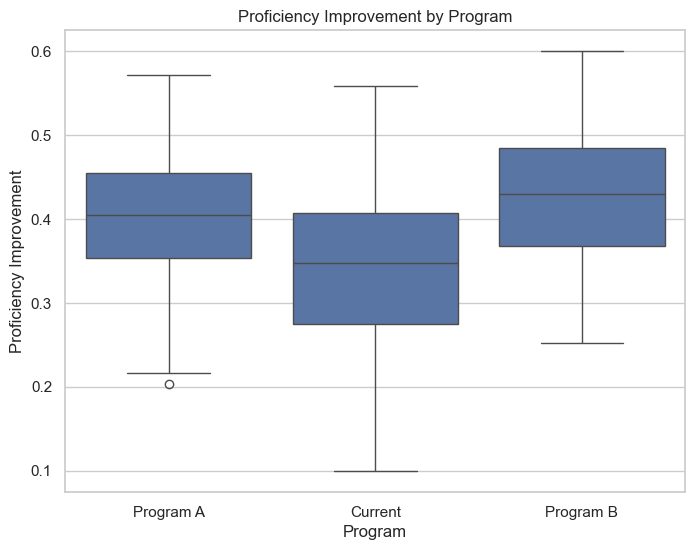

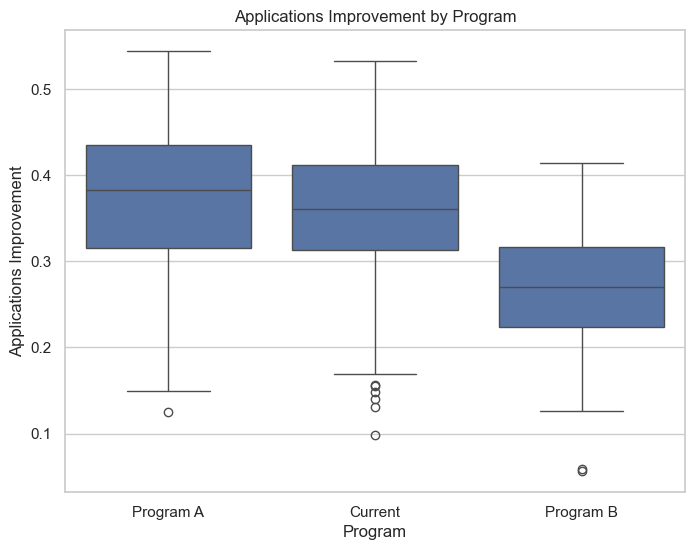

In [7]:
## Creating Boxplots for both Proficiency and Applicaiton between each groups
sns.set(style="whitegrid")

# Define the figure size
figsize = (8, 6)

# Boxplot for Proficiency Improvement
plt.figure(figsize=figsize)
sns.boxplot(data=data, x='Program', y='Proficiency_Improvement')
plt.title("Proficiency Improvement by Program")
plt.ylabel("Proficiency Improvement")
plt.xlabel("Program")
plt.show()

# Boxplot for Applications Improvement
plt.figure(figsize=figsize)
sns.boxplot(data=data, x='Program', y='Applications_Improvement')
plt.title("Applications Improvement by Program")
plt.ylabel("Applications Improvement")
plt.xlabel("Program")
plt.show()

In [8]:
## Check Normality and Homogenity for both Proficiency and Application Imporvment

## Checks for Normality for all programs for all 3 groups
print("Shapiro-Wilk Test for Normality:\n")

for program in ['Program A', 'Program B', 'Current']:
    prof_data = data.loc[data['Program'] == program, 'Proficiency_Improvement']
    app_data = data.loc[data['Program'] == program, 'Applications_Improvement']
    
    prof_shapiro = shapiro(prof_data)
    app_shapiro = shapiro(app_data)
    
    print(f"{program} - Proficiency Improvement: p-value = {prof_shapiro.pvalue:.4f}")
    print(f"{program} - Applications Improvement: p-value = {app_shapiro.pvalue:.4f}")
    print("-" * 50)

print("\nLevene's Test for Equal Variance:\n")

# Proficiency Improvement
levene_prof = levene(
    data.loc[data['Program'] == 'Program A', 'Proficiency_Improvement'],
    data.loc[data['Program'] == 'Program B', 'Proficiency_Improvement'],
    data.loc[data['Program'] == 'Current', 'Proficiency_Improvement']
)
print(f"Levene's Test - Proficiency Improvement: p-value = {levene_prof.pvalue:.4f}")

# Applications Improvement
levene_app = levene(
    data.loc[data['Program'] == 'Program A', 'Applications_Improvement'],
    data.loc[data['Program'] == 'Program B', 'Applications_Improvement'],
    data.loc[data['Program'] == 'Current', 'Applications_Improvement']
)
print(f"Levene's Test - Applications Improvement: p-value = {levene_app.pvalue:.4f}")



Shapiro-Wilk Test for Normality:

Program A - Proficiency Improvement: p-value = 0.2971
Program A - Applications Improvement: p-value = 0.0418
--------------------------------------------------
Program B - Proficiency Improvement: p-value = 0.0694
Program B - Applications Improvement: p-value = 0.2375
--------------------------------------------------
Current - Proficiency Improvement: p-value = 0.0458
Current - Applications Improvement: p-value = 0.0013
--------------------------------------------------

Levene's Test for Equal Variance:

Levene's Test - Proficiency Improvement: p-value = 0.0061
Levene's Test - Applications Improvement: p-value = 0.2520


### Since not all groups follows nornality and not all groups have homogeneity of variance, Kruskall-Wallis Test will be better than ANOVA.

In [9]:
## Use Kruskall-Wallis to test if there is a difference in Proficiency and Application
# Kruskal-Wallis Test
print("Kruskal-Wallis Test for Proficiency and Applications Improvement:\n")

# Extract the groups
prof_a = data.loc[data['Program'] == 'Program A', 'Proficiency_Improvement']
prof_b = data.loc[data['Program'] == 'Program B', 'Proficiency_Improvement']
prof_current = data.loc[data['Program'] == 'Current', 'Proficiency_Improvement']

app_a = data.loc[data['Program'] == 'Program A', 'Applications_Improvement']
app_b = data.loc[data['Program'] == 'Program B', 'Applications_Improvement']
app_current = data.loc[data['Program'] == 'Current', 'Applications_Improvement']

# Kruskal-Wallis for Proficiency Improvement
kruskal_prof = kruskal(prof_a, prof_b, prof_current)
print(f"Proficiency Improvement - Kruskal-Wallis p-value: {kruskal_prof.pvalue:.4f}")
if kruskal_prof.pvalue < 0.05:
    print("Result: Significant differences exist between groups (perform Dunn's Test).\n")
else:
    print("Result: No significant differences found.\n")

# Kruskal-Wallis for Applications Improvement
kruskal_app = kruskal(app_a, app_b, app_current)
print(f"Applications Improvement - Kruskal-Wallis p-value: {kruskal_app.pvalue:.4f}")
if kruskal_app.pvalue < 0.05:
    print("Result: Significant differences exist between groups (perform Dunn's Test).\n")
else:
    print("Result: No significant differences found.\n")

Kruskal-Wallis Test for Proficiency and Applications Improvement:

Proficiency Improvement - Kruskal-Wallis p-value: 0.0000
Result: Significant differences exist between groups (perform Dunn's Test).

Applications Improvement - Kruskal-Wallis p-value: 0.0000
Result: Significant differences exist between groups (perform Dunn's Test).



In [10]:
## Use Post-Hoc Dunn's Test for Pairwise Comparison to see which Program are performing better
# Post-Hoc Dunn's Test for Pairwise Comparisons
print("Performing Post-Hoc Dunn's Test with Confidence Intervals:\n")

# Combine data for Dunn's test
proficiency_data = [prof_a, prof_b, prof_current]
applications_data = [app_a, app_b, app_current]

# Dunn's Test for Proficiency Improvement
dunn_prof = sp.posthoc_dunn([prof_a, prof_b, prof_current], p_adjust='bonferroni')
print("Dunn's Test for Proficiency Improvement:")
print(dunn_prof)

# Dunn's Test for Applications Improvement
dunn_app = sp.posthoc_dunn([app_a, app_b, app_current], p_adjust='bonferroni')
print("\nDunn's Test for Applications Improvement:")
print(dunn_app)

# Confidence Intervals
def confidence_intervals(group, confidence=0.95):
    mean = np.mean(group)
    se = np.std(group) / np.sqrt(len(group))
    margin = se * 1.96  # Z-score for 95% CI
    lower = mean - margin
    upper = mean + margin
    return lower, upper

# Compute Confidence Intervals
print("\nConfidence Intervals for Proficiency Improvement:")
for program, group in zip(["Program A", "Program B", "Current"], [prof_a, prof_b, prof_current]):
    ci_lower, ci_upper = confidence_intervals(group)
    print(f"{program}: [{ci_lower:.4f}, {ci_upper:.4f}]")

print("\nConfidence Intervals for Applications Improvement:")
for program, group in zip(["Program A", "Program B", "Current"], [app_a, app_b, app_current]):
    ci_lower, ci_upper = confidence_intervals(group)
    print(f"{program}: [{ci_lower:.4f}, {ci_upper:.4f}]")

Performing Post-Hoc Dunn's Test with Confidence Intervals:

Dunn's Test for Proficiency Improvement:
              1             2             3
1  1.000000e+00  6.082267e-02  2.530918e-10
2  6.082267e-02  1.000000e+00  1.343081e-19
3  2.530918e-10  1.343081e-19  1.000000e+00

Dunn's Test for Applications Improvement:
              1             2             3
1  1.000000e+00  1.554332e-31  1.354350e-01
2  1.554332e-31  1.000000e+00  3.041735e-26
3  1.354350e-01  3.041735e-26  1.000000e+00

Confidence Intervals for Proficiency Improvement:
Program A: [0.3918, 0.4139]
Program B: [0.4158, 0.4392]
Current: [0.3274, 0.3511]

Confidence Intervals for Applications Improvement:
Program A: [0.3649, 0.3877]
Program B: [0.2591, 0.2786]
Current: [0.3469, 0.3670]


### Proficiency Improvement Results
Interpretation:
1. Program A vs Program B: No significant difference (p = 0.06).
2. Program A vs Current: Significant difference (p < 0.05), indicating Program A outperforms Current.
3. Program B vs Current: Significant difference (p < 0.05), indicating Program B outperforms Current.

### Application Application Results
Interpretation:
1. Program A vs Program B: Significant difference (p < 0.05), indicating Program A outperforms Program B.
2. Program A vs Current: No significant difference (p = 0.14).
3. Program B vs Current: Significant difference (p < 0.05), indicating Current outperforms Program B.

In [12]:
from scipy.stats import mannwhitneyu
import numpy as np
import pandas as pd

# Function to compute Cohen's d
def cohens_d(group1, group2):
    mean_diff = np.mean(group1) - np.mean(group2)
    pooled_std = np.sqrt((np.std(group1, ddof=1)**2 + np.std(group2, ddof=1)**2) / 2)
    return mean_diff / pooled_std

# Function to calculate Confidence Interval for Mean Difference
def confidence_interval(group1, group2):
    mean_diff = np.mean(group1) - np.mean(group2)
    se_diff = np.sqrt((np.std(group1, ddof=1)**2 / len(group1)) + (np.std(group2, ddof=1)**2 / len(group2)))
    ci_lower = mean_diff - 1.96 * se_diff
    ci_upper = mean_diff + 1.96 * se_diff
    return mean_diff, ci_lower, ci_upper

# Function to perform all tests and return results
def perform_tests(group1, group2, label1, label2, metric):
    # Mann-Whitney U Test
    u_stat, p_value = mannwhitneyu(group1, group2, alternative='two-sided')
    
    # Cohen's d
    d_value = cohens_d(group1, group2)
    
    # Confidence Interval
    mean_diff, ci_lower, ci_upper = confidence_interval(group1, group2)
    
    return {
        "Metric": metric,
        "Comparison": f"{label1} vs {label2}",
        "Mann-Whitney p-value": round(p_value, 4),
        "Cohen's d": round(d_value, 4),
        "Mean Difference": round(mean_diff, 4),
        "95% CI Lower": round(ci_lower, 4),
        "95% CI Upper": round(ci_upper, 4)
    }

# Extract groups
prof_a = data.loc[data['Program'] == 'Program A', 'Proficiency_Improvement']
prof_b = data.loc[data['Program'] == 'Program B', 'Proficiency_Improvement']
prof_current = data.loc[data['Program'] == 'Current', 'Proficiency_Improvement']

app_a = data.loc[data['Program'] == 'Program A', 'Applications_Improvement']
app_b = data.loc[data['Program'] == 'Program B', 'Applications_Improvement']
app_current = data.loc[data['Program'] == 'Current', 'Applications_Improvement']

# Perform pairwise comparisons for Proficiency Improvement
results = []
results.append(perform_tests(prof_a, prof_b, "Program A", "Program B", "Proficiency"))
results.append(perform_tests(prof_a, prof_current, "Program A", "Current", "Proficiency"))
results.append(perform_tests(prof_b, prof_current, "Program B", "Current", "Proficiency"))

# Perform pairwise comparisons for Applications Improvement
results.append(perform_tests(app_a, app_b, "Program A", "Program B", "Applications"))
results.append(perform_tests(app_a, app_current, "Program A", "Current", "Applications"))
results.append(perform_tests(app_b, app_current, "Program B", "Current", "Applications"))

# Convert results to DataFrame
results_df = pd.DataFrame(results)

# Display the results
print("\nPairwise Comparison Results:\n")
print(results_df.to_string(index=False))


Pairwise Comparison Results:

      Metric             Comparison  Mann-Whitney p-value  Cohen's d  Mean Difference  95% CI Lower  95% CI Upper
 Proficiency Program A vs Program B                0.0075    -0.3163          -0.0246       -0.0408       -0.0085
 Proficiency   Program A vs Current                0.0000     0.7575           0.0636        0.0474        0.0799
 Proficiency   Program B vs Current                0.0000     1.0080           0.0883        0.0716        0.1049
Applications Program A vs Program B                0.0000     1.4905           0.1074        0.0924        0.1225
Applications   Program A vs Current                0.0256     0.2497           0.0194        0.0041        0.0346
Applications   Program B vs Current                0.0000    -1.1927          -0.0881       -0.1021       -0.0740


## Interpretation

### Proficiency Improvement
- Program B has the highest improvement in Proficiency.
    - Statistically significant difference (p < 0.05) compared to both Program A and Current.
    - Cohen's d = 1.008 (large effect size), showing substantial improvement.
- Program A outperforms the Current Program significantly with a medium effect size (0.7575).
- Program A vs B: Program B shows a statistically significant advantage over A, but the effect size is small (-0.3163).

### Application Improvement
- Program A is the top performer for Applications Improvement.
    - Large effect size (1.4905) when compared to Program B.
    - Small but significant improvement over Current (p = 0.0256, Cohen's d = 0.2497).
- Program B performs the worst:
    - Statistically significantly lower than Current (p < 0.05, Cohen's d = -1.1927).

## Overall Summary:
Proficiency Improvement:
- Program B is the best performer with a large effect size over Current and a small edge over Program A.
- Program A also outperforms the Current Program.
Applications Improvement:
- Program A is the best performer with significant improvement over Program B and slight improvement over Current.
- Program B performs significantly worse than both A and Current.

## Recommendations:
1. For Proficiency Improvement: Program B is the strongest choice.
2. For Applications Improvement: Program A is the clear winner.
3. Program B should be revisited or improved, especially for Applications Improvement.


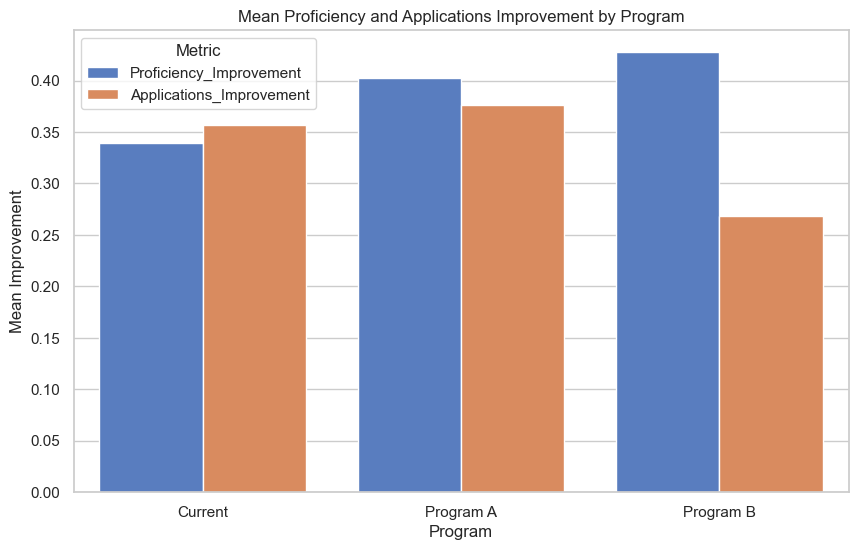

In [13]:
# Calculate the means for Proficiency and Applications Improvement by Program
group_means = data.groupby('Program').agg({
    'Proficiency_Improvement': 'mean',
    'Applications_Improvement': 'mean'
}).reset_index()

# Melt the DataFrame for easier plotting with Seaborn
group_means_melted = group_means.melt(id_vars='Program', 
                                      value_vars=['Proficiency_Improvement', 'Applications_Improvement'],
                                      var_name='Metric', value_name='Mean Improvement')

# Plot the Bar Chart
plt.figure(figsize=(10, 6))
sns.barplot(data=group_means_melted, x='Program', y='Mean Improvement', hue='Metric', palette='muted')
plt.title('Mean Proficiency and Applications Improvement by Program')
plt.ylabel('Mean Improvement')
plt.xlabel('Program')
plt.legend(title='Metric')
plt.show()